# Passenger survival prediction in Titanic: Building GBM model

This building of this model was guided by a tutorial in analyticsvidhiya: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

## Import libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import model_selection, metrics
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']= 12,4

## Load data

In [3]:
train = pd.read_csv('train_modified.csv')
test = pd.read_csv('test_modified.csv')

In [4]:
target = 'Survived'
IDcol = 'PassengerId'

In [5]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

## Define a function for modeling and cross-validation

This function will do the following:

1. fit the model
2. determine training accuracy
3. determine training AUC
4. determine testing AUC
5. perform CV if performCV is True
6. plot Feature Importance if printFeatureImportance is True


In [6]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Survived'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = model_selection.cross_val_score(alg, dtrain[predictors], dtrain['Survived'], 
                                                    cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Survived'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Survived'],dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score), 
                                 np.std(cv_score), np.min(cv_score), np.max(cv_score)))
                
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, index=predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

## Baseline model

In this case, the evaluation metric is AUC so using any constant value will give 0.5 as result. Typically, a good baseline can be a GBM model with default parameters, i.e. without any tuning. Lets find out what it gives:


Model Report
Accuracy : 0.8979
AUC Score (Train): 0.950513
CV Score : Mean - 0.880906 | Std - 0.03950195 | Min - 0.8151515 | Max - 0.9247841


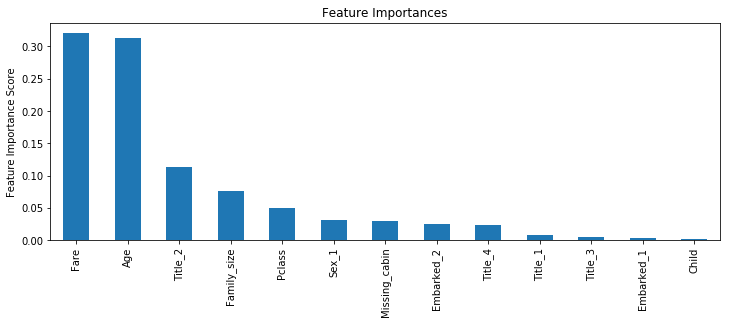

In [7]:
predictors = [feat for feat in train.columns if feat not in [target, IDcol]]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, train, predictors)

## GBM models

There are 2 types of parameters:

1. Tree-specific parameters
    * min_samples_split
    * min_samples_leaf
    * max_depth
    * min_leaf_nodes
    * max_features
    * loss function
2. Boosting specific paramters
    * n_estimators
    * learning_rate
    * subsample


## Approach for tackling the problem

1. Decide a relatively higher value for learning rate and tune the number of estimators requried for that.
2. Tune the tree specific parameters for that learning rate
3. Tune subsample
4. Lower learning rate as much as possible computationally and increase the number of estimators accordingly.


## Step 1- Find the number of estimators for a high learning rate

We will use the following benchmarks for parameters:
1. min_samples_split = 5 : ~0.5-1% of total values.
2. min_samples_leaf = 5 : Just using for preventing overfitting. will be tuned later.
3. max_depth = 2
4. max_features = 'sqrt' : general thumbrule to start with subsample = 0.8 : typically used value (will be tuned later)

0.1 is assumed to be a good learning rate to start with. Let's try to find the optimum number of estimators requried for this.

In [8]:
predictors = [feat for feat in train.columns if feat not in [target, IDcol]]
param_test1 = {'n_estimators': np.arange(20, 81, 10)}
gsearch1 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.1, min_samples_split=5,
        min_samples_leaf=5, max_depth=2, max_features='sqrt', subsample=0.8,random_state=10), 
                param_grid=param_test1, n_jobs=-1, scoring='roc_auc', iid=False, cv=5)
gsearch1.fit(train[predictors], train[target])


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=5, min_samples_split=5,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'n_estimators': array([20, 30, 40, 50, 60, 70, 80])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [10]:
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 0.07074819,  0.08593678,  0.08036056,  0.08244729,  0.09744987,
          0.10766788,  0.11096387]),
  'mean_score_time': array([ 0.00302553,  0.00239749,  0.00249772,  0.00236721,  0.00246177,
          0.00230079,  0.00208282]),
  'mean_test_score': array([ 0.85841868,  0.86761845,  0.87219064,  0.87453186,  0.87522009,
          0.87451985,  0.87457329]),
  'mean_train_score': array([ 0.87138485,  0.87994808,  0.88548728,  0.88890591,  0.8920539 ,
          0.89440239,  0.89709969]),
  'param_n_estimators': masked_array(data = [20 30 40 50 60 70 80],
               mask = [False False False False False False False],
         fill_value = ?),
  'params': [{'n_estimators': 20},
   {'n_estimators': 30},
   {'n_estimators': 40},
   {'n_estimators': 50},
   {'n_estimators': 60},
   {'n_estimators': 70},
   {'n_estimators': 80}],
  'rank_test_score': array([7, 6, 5, 3, 1, 4, 2], dtype=int32),
  'split0_test_score': array([ 0.84196311,  0.86054018,  0.86660079,  

## Step 2- Tune tree-specific parameters

Now, lets move onto tuning the tree parameters:

1. Tune max_depth and min_samples_split
2. Tune min_samples_leaf
3. Tune max_features


In [11]:
#Grid seach on max_depth and min_samples_split
param_test2 = {'max_depth':np.arange(2,11,1), 'min_samples_split':np.arange(3,20,2)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,
                                                max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]), 'min_samples_split': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [12]:
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([ 0.11461825,  0.10187316,  0.09737225,  0.09812794,  0.10004711,
          0.09643679,  0.09616537,  0.10296593,  0.11369061,  0.12785807,
          0.14765449,  0.12613406,  0.13109288,  0.13219028,  0.12265816,
          0.14994879,  0.1757441 ,  0.1675869 ,  0.1862587 ,  0.18064518,
          0.26999426,  0.20511365,  0.1692318 ,  0.16795154,  0.18827429,
          0.1608727 ,  0.17615638,  0.25962372,  0.23575311,  0.22317076,
          0.22297373,  0.2147265 ,  0.20706549,  0.20250835,  0.20027561,
          0.19694877,  0.35940604,  0.32816725,  0.30433311,  0.28780594,
          0.27807527,  0.26409893,  0.26123538,  0.25282106,  0.24189119,
          0.51889443,  0.44416442,  0.39821205,  0.37124743,  0.3434896 ,
          0.32584629,  0.31098933,  0.29640317,  0.28563099,  0.72517962,
          0.58592896,  0.50750499,  0.45129957,  0.42456107,  0.39051094,
          0.36649976,  0.35023031,  0.33068547,  0.92857962,  0.7814651 ,
          0.6221139 ,

In [13]:
#Grid seach on min_samples_leaf
param_test3 = {'min_samples_leaf':np.arange(1,30,2)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_depth=7,
                                  min_samples_split=11, max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=7,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=11,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [14]:
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([ 0.36385908,  0.31144972,  0.2937417 ,  0.26086926,  0.23554988,
          0.22202787,  0.21203814,  0.19371805,  0.18315549,  0.17938805,
          0.18070626,  0.16422844,  0.1573523 ,  0.15226965,  0.14435873]),
  'mean_score_time': array([ 0.00369492,  0.00292654,  0.00295472,  0.00294156,  0.00283017,
          0.00283141,  0.00277834,  0.00280991,  0.00272574,  0.00279045,
          0.00277452,  0.00273514,  0.00271349,  0.00268974,  0.0024272 ]),
  'mean_test_score': array([ 0.87673514,  0.87076028,  0.86813689,  0.8714886 ,  0.87495734,
          0.87423532,  0.87426827,  0.87600674,  0.87515791,  0.87555527,
          0.87600196,  0.87830764,  0.87758085,  0.87695461,  0.87719158]),
  'mean_train_score': array([ 0.98687268,  0.98097873,  0.9775849 ,  0.9703668 ,  0.96289818,
          0.95767451,  0.95227587,  0.94844184,  0.94405758,  0.94126196,
          0.93699292,  0.93349692,  0.93162064,  0.92843712,  0.92564956]),
  'param_min_samples_leaf': m

Let’s fit the model again on this and have a look at the feature importance.


Model Report
Accuracy : 0.8721
AUC Score (Train): 0.932251
CV Score : Mean - 0.8783076 | Std - 0.02702437 | Min - 0.8397233 | Max - 0.9203319


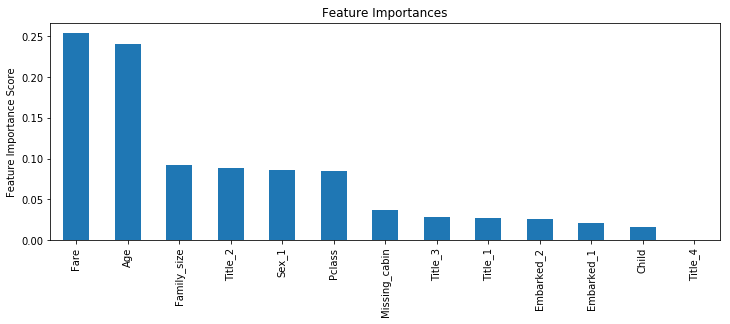

In [15]:
modelfit(gsearch3.best_estimator_, train, predictors)

As we can see, the importance is fairly distributed between different features as opposed to the baseline model.

Tuning max_features

In [16]:
#Grid seach on max_features
param_test4 = {'max_features':np.arange(3,13,1)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_depth=7,
                                  min_samples_split=11, min_samples_leaf=23, subsample=0.8, random_state=10), 
                       param_grid = param_test4, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=7,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=23, min_samples_split=11,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'max_features': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [17]:
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([ 0.40874028,  0.17581553,  0.18404207,  0.19853125,  0.19853053,
          0.20816283,  0.21244645,  0.21973572,  0.22320089,  0.19941239]),
  'mean_score_time': array([ 0.15477161,  0.00279508,  0.00286255,  0.00278516,  0.00275798,
          0.00280461,  0.00280299,  0.0028811 ,  0.00283189,  0.0024611 ]),
  'mean_test_score': array([ 0.87830764,  0.87756978,  0.87796069,  0.87795849,  0.87961095,
          0.87628101,  0.87782459,  0.88030906,  0.8772502 ,  0.87937144]),
  'mean_train_score': array([ 0.93349692,  0.94055994,  0.9451535 ,  0.94971086,  0.95219498,
          0.95430221,  0.95638474,  0.95784961,  0.95880795,  0.96026892]),
  'param_max_features': masked_array(data = [3 4 5 6 7 8 9 10 11 12],
               mask = [False False False False False False False False False False],
         fill_value = ?),
  'params': [{'max_features': 3},
   {'max_features': 4},
   {'max_features': 5},
   {'max_features': 6},
   {'max_features': 7},
   {'max_featu

we have the final tree-parameters as:
- min_samples_split: 11
- min_samples_leaf: 23
- max_depth: 7
- max_features: 10


## Step3- Tune Subsample and Lower Learning Rate

In [18]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_depth=7,
                                  min_samples_split=11, min_samples_leaf=23, max_features=10, random_state=10), 
                       param_grid = param_test5, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=7,
              max_features=10, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=23, min_samples_split=11,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [19]:
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([ 0.24906607,  0.20541196,  0.21937304,  0.22100959,  0.22288804,
          0.20602007]),
  'mean_score_time': array([ 0.00346336,  0.0027988 ,  0.00280027,  0.00282226,  0.00281086,
          0.00242848]),
  'mean_test_score': array([ 0.87692189,  0.88079032,  0.88152745,  0.88030906,  0.87494239,
          0.87652555]),
  'mean_train_score': array([ 0.94710339,  0.9545782 ,  0.95536328,  0.95784961,  0.96055075,
          0.96125259]),
  'param_subsample': masked_array(data = [0.6 0.7 0.75 0.8 0.85 0.9],
               mask = [False False False False False False],
         fill_value = ?),
  'params': [{'subsample': 0.6},
   {'subsample': 0.7},
   {'subsample': 0.75},
   {'subsample': 0.8},
   {'subsample': 0.85},
   {'subsample': 0.9}],
  'rank_test_score': array([4, 2, 1, 3, 6, 5], dtype=int32),
  'split0_test_score': array([ 0.86429513,  0.87483531,  0.87588933,  0.86627141,  0.8654809 ,
          0.86824769]),
  'split0_train_score': array([ 0.9457767 ,  

Now, we need to lower the learning rate and increase the number of estimators proportionally.


Model Report
Accuracy : 0.8967
AUC Score (Train): 0.957775
CV Score : Mean - 0.8772529 | Std - 0.03005328 | Min - 0.8277339 | Max - 0.9098084


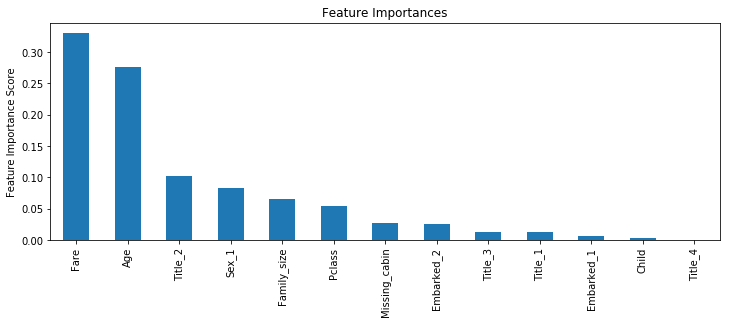

In [20]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=120,max_depth=7, min_samples_split=11, 
                                         min_samples_leaf=23, subsample=0.75, max_features=10, random_state=10)
modelfit(gbm_tuned_1, train, predictors)


Model Report
Accuracy : 0.8945
AUC Score (Train): 0.956859
CV Score : Mean - 0.8778803 | Std - 0.02874807 | Min - 0.8301054 | Max - 0.9083243


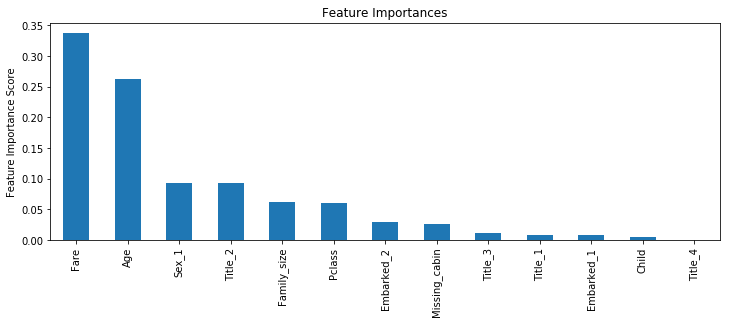

In [21]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=600, max_depth=7, min_samples_split=11, 
                                         min_samples_leaf=23, subsample=0.75, max_features=10, random_state=10)
modelfit(gbm_tuned_2, train, predictors)


Model Report
Accuracy : 0.9012
AUC Score (Train): 0.957743


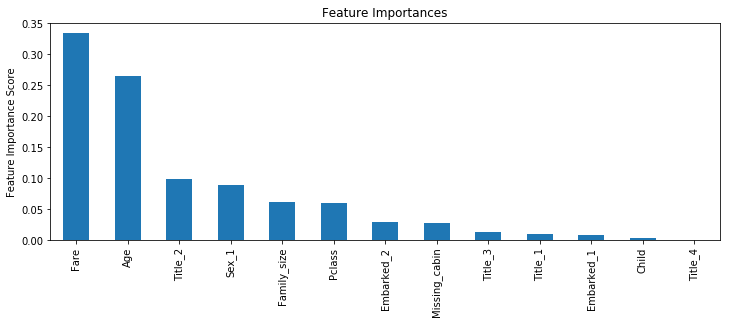

In [22]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_3 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1200,max_depth=7, min_samples_split=11, 
                                         min_samples_leaf=23, subsample=0.75, max_features=10, random_state=10)
modelfit(gbm_tuned_3, train, predictors, performCV=False)


Model Report
Accuracy : 0.908
AUC Score (Train): 0.967788


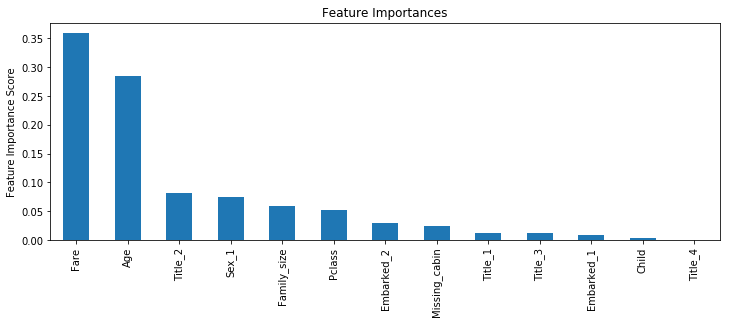

In [25]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_4 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1600,max_depth=7, min_samples_split=11, 
                                         min_samples_leaf=23, subsample=0.75, max_features=10, random_state=10)
modelfit(gbm_tuned_4, train, predictors, performCV=False)

In [24]:
gbm_final = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1600,max_depth=7, min_samples_split=11, 
                                         min_samples_leaf=23, subsample=0.75, max_features=10, random_state=0)
gbm_final.fit(train[predictors], train['Survived'])
my_prediction=gbm_final.predict(test[predictors]).astype(int)

In [26]:
PassengerId =np.array(test["PassengerId"]).astype(int)
my_solution = pd.DataFrame(my_prediction, PassengerId, columns = ["Survived"])

In [27]:
my_solution.to_csv("my_submission.csv", index_label = ["PassengerId"])

In [28]:
my_solution.shape

(418, 1)

In [29]:
gbm_final.score(train[predictors], train[target])

0.90572390572390571